# DSMCER Notebook 9 - Feature Engineering 2

1. More feature extraction
   1. _Poll_: List some possible features
   2. Molecules
2. Feature selection
   1. By filtering
   2. Forward and reverse selection
   3. PCA
3. Note on end-to-end selection

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.ensemble

import codecarbon
import xgboost

# ! NEW
import rdkit.Chem
import rdkit.Chem.Descriptors
import rdkit.Chem.rdMolDescriptors
import rdkit.ML.Descriptors.MoleculeDescriptors

***
***

## 1. More feature extraction

<font size=5><center> In our first SML lecture, we encoded nominal variables (the identity of DES agents) with OneHotEncoding:

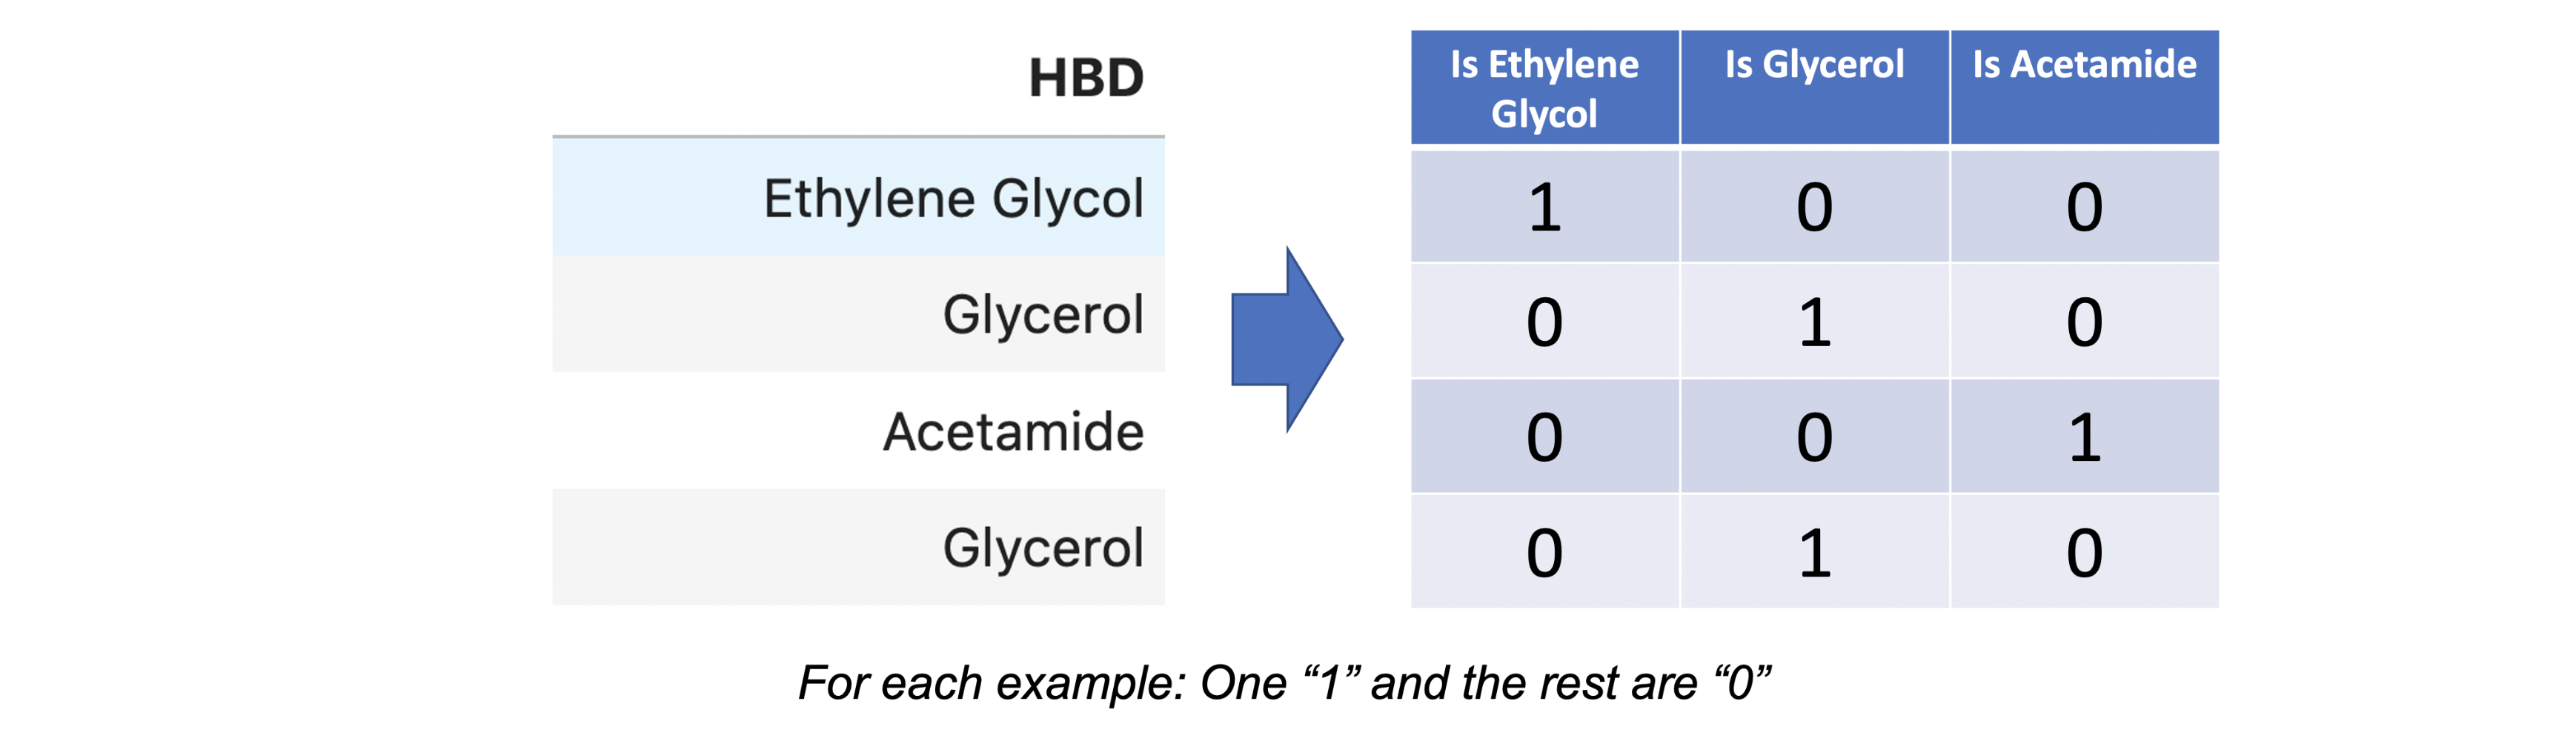

<font size=5><center> This was a rudimentary form of *feature selection*, but it is limited to the case when future examples __never have new nominal values__. 

***

### A. _Poll_: List some possible features

<font size=4> To create an SML model that would function __for new molecules not seen in training__ we had to engineer some new features that we expected to effect the DES mixture like molar mass and melting point. 
    
<font size=4><center> __Consider the following problem statement__: Create a predictor of human longevity.</center>
    
<font size=4>It would not be useful to OneHotEncode people, because the people we want to make predictions for are different from the ones we can take data for. __List some features we could extract from a person to try to predict their lifespan__?

***

### B. Molecules

<font size=5><center> __What features we can extract are task dependant__, but there are common things we can do for molecules and materials. 

<font size=4>__Hopefully working through this example of extracting features for molecules will give you a bigger picture of feature extraction for other examples__. It may also be that you end up working with molecules. Enter the `rdkit` molecules object:

In [4]:
help(rdkit.Chem.Mol)

Help on class Mol in module rdkit.Chem.rdchem:

class Mol(Boost.Python.instance)
 |  The Molecule class.
 |  
 |  In addition to the expected Atoms and Bonds, molecules contain:
 |    - a collection of Atom and Bond bookmarks indexed with integers
 |        that can be used to flag and retrieve particular Atoms or Bonds
 |        using the {get|set}{Atom|Bond}Bookmark() methods.
 |  
 |    - a set of string-valued properties. These can have arbitrary string
 |        labels and can be set and retrieved using the {set|get}Prop() methods
 |        Molecular properties can be tagged as being *computed*, in which case
 |          they will be automatically cleared under certain circumstances (when the
 |          molecule itself is modified, for example).
 |        Molecules also have the concept of *private* properties, which are tagged
 |          by beginning the property name with an underscore (_).
 |  
 |  Method resolution order:
 |      Mol
 |      Boost.Python.instance
 |      bui

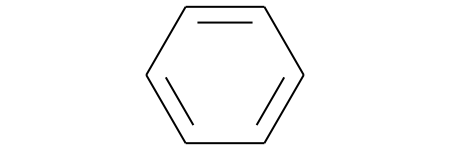

In [5]:
benzene = rdkit.Chem.MolFromSmiles('c1ccccc1')
benzene

<font size=4>*A note on "SMILES" stings. [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) (__S__ implified __M__ olecular-__I__ nput __L__ ine-__E__ ntry __S__ tring) defines the atoms in a molecule and the bonding pattern of the atoms. Please see the resource for more information.*

<font size=4>`rdkit` allows us to quickly extract many features from the SMILES string:

In [6]:
my_features = ['MolLogP', 'NumAromaticRings', 'MolWt']

In [7]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

In [8]:
calculator.CalcDescriptors(benzene)

(1.6866, 1, 78.11399999999999)

<font size=4>Instead of chosing specific descriptors, we might just extract them all... that is where the next section comes in ;)

In [9]:
all_descriptors = [name for name, _ in rdkit.Chem.Descriptors._descList]
print(all_descriptors)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [10]:
calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(all_descriptors)

In [11]:
features = calculator.CalcDescriptors(benzene)
print(features)

(2.0, 2.0, 2.0, 2.0, 0.4426283718993647, 78.11399999999999, 72.06599999999999, 78.046950192, 30, 0, -0.062268570782092456, -0.062268570782092456, 0.062268570782092456, 0.062268570782092456, 0.3333333333333333, 0.5, 0.6666666666666666, 13.646993161855445, 10.379006838144555, 1.5737245910733604, -1.6942617326375449, 1.794093161855452, -1.4738931618554547, 4.985993161855456, 1.718006838144549, 3.000000000000001, 71.96100505779535, 4.242640687119286, 3.464101615137755, 3.464101615137755, 3.0, 2.0000000000000004, 2.0000000000000004, 1.1547005383792521, 1.1547005383792521, 0.6666666666666671, 0.6666666666666671, 0.38490017945975075, 0.38490017945975075, -0.78, 34.3994618804395, 3.4115708812260532, 1.6057694396735218, 0.5823992601400448, 37.43140311949697, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 36.39820241076966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

<font size=4>Each one of these __describes something physically interpretable about the molecule__. This type of feature is called a *descriptor*. 
    
<font size=4>Let's extract some descriptors for the whole dataset.

***

In [90]:
# load the data by downloading it
df = pd.read_csv('http://faculty.washington.edu/dacb/HCEPDB_moldata.zip').sample(500, random_state=201)

<font size=4>Use the smiles to compute features

In [91]:
my_features = ['FractionCSP3', 'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR']
my_calculator = rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator(my_features)

def smiles_to_descriptors(smiles, calculator=my_calculator):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    descriptors = calculator.CalcDescriptors(mol)
    return descriptors

In [92]:
descriptors = np.vstack(
    df['SMILES_str'].apply(smiles_to_descriptors))

[13:48:48] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8 10 11 12 13 15 16 17 18 19 20 21 23 24 25
Traceback (most recent call last):
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/Chem/Lipinski.py", line 90, in <lambda>
    _fn = lambda x, y=_cfn: y(x)
Boost.Python.ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcFractionCSP3(NoneType)
did not match C++ signature:
    CalcFractionCSP3(RDKit::ROMol mol)
Traceback (most recent call last):
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/rdkit/Chem/Lipinski.py", line 78, in HeavyAtom

<font size=4>__Notice how there were some errors?__ I won't dive into why, but suffice it to say that some of these descriptors don't work for certain types of molecules. In this case, RDKit gives back "-666" (spooky). There aren't really values, we want to replace these with `NaN` to make sure they don't slip through to the ML model

In [93]:
np.isclose(descriptors, -666.0).sum()

20

<font size=4>Add all the data back into a dataframe to make this easier

In [117]:
new_df = pd.DataFrame(descriptors)
new_df = new_df.rename(columns=lambda col_name: f"x{col_name}")

In [118]:
new_df['y'] = df['e_gap_alpha'].values

<font size=4>Fix all of the -666

In [119]:
new_df = new_df.replace(to_replace=-666.0, value=None).astype('Float64')

In [121]:
new_df.describe()

x0          x1          x2          x3          x4          x5  \
count  499.000000  499.000000  499.000000  499.000000  499.000000  499.000000   
mean     0.019788   27.396794    0.649299    2.853707    0.452906    0.468938   
std      0.028154    3.639761    0.746649    1.566671    0.642603    0.658995   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   25.000000    0.000000    2.000000    0.000000    0.000000   
50%      0.000000   28.000000    1.000000    3.000000    0.000000    0.000000   
75%      0.041667   30.000000    1.000000    4.000000    1.000000    1.000000   
max      0.142857   34.000000    3.000000    8.000000    3.000000    4.000000   

               x6          x7          x8          x9  ...         x11  \
count  499.000000  499.000000  499.000000  499.000000  ...  499.000000   
mean     0.921844    1.887776    3.859719    5.747495  ...    0.649299   
std      0.852532    1.178553    1.250044    1.232251  ...    0.746649   
min      0.000000    0.000000    0.000000    2.000000  ...    0.000000   
25%      0.000000    1.000000    3.000000    5.000000  ...    0.000000   
50%      1.000000    2.000000    4.000000    6.000000  ...    1.000000   
75%      1.000000    3.000000    5.000000    7.000000  ...    1.000000   
max      4.000000    5.000000    8.000000    9.000000  ...    3.000000   

              x12         x13    x14    x15    x16         x17         x18  \
count  499.000000  499.000000  499.0  499.0  499.0  499.000000  499.000000   
mean     5.206413    1.368737    0.0    0.0    0.0    6.669339    5.187807   
std      1.785562    0.833718    0.0    0.0    0.0    1.010428    1.933561   
min      1.000000    0.000000    0.0    0.0    0.0    4.000000   -3.671000   
25%      4.000000    1.000000    0.0    0.0    0.0    6.000000    3.978200   
50%      5.000000    1.000000    0.0    0.0    0.0    7.000000    5.353900   
75%      6.000000    1.000000    0.0    0.0    0.0    7.000000    6.691600   
max     12.000000    3.000000    0.0    0.0    0.0    9.000000    9.648000   

              x19           y  
count  499.000000  500.000000  
mean   118.177697    1.900399  
std     16.167400    0.407654  
min     61.444700    0.800672  
25%    107.740500    1.616958  
50%    120.813000    1.863972  
75%    131.169050    2.181222  
max    146.188000    3.002850  

[8 rows x 21 columns]

***

## 2. Feature Selection

<font size=4> One of the first things we often do is handle Null values. The ML model cannot deal with Null values. __We have a few options:__
    
1. <font size=4> Remove the datapoints that have nans. This is a good choice if there are only a few or you have __a lot__ of data
    
2. <font size=4> __Impute them__, for example by filling the Null values with the average over the rest of the data. We will not cover this explicity but if you have lots of Null values or a small dataset, it may be worth it. See more information [here](https://scikit-learn.org/stable/modules/impute.html|) 

In [131]:
new_df.isna().any(axis=1).sum()

1

<font size=4>There is only a sinlg example in the dataset with NaN values, let's just drop them.

In [132]:
new_df = new_df.dropna()

In [133]:
new_df.shape

(499, 21)

<font size=4>We are doing machine learning. Remember __we must always__ save a test set and put it aside until the end. For a goal of "Predict energy gap for new compounds" a random split is likely sufficient, assuming we are not using new elements in the future. 

In [134]:
dev, test = sklearn.model_selection.train_test_split(new_df, test_size=.15 )

<font size=5><center>Feature selection is concerned with __determining if any of our features are not useful or just extra noise.__

<font size=3> Let's look at a visual to get an idea:

/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ek/miniconda3/envs/DSMCER_general_env/lib/python3.8/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, t

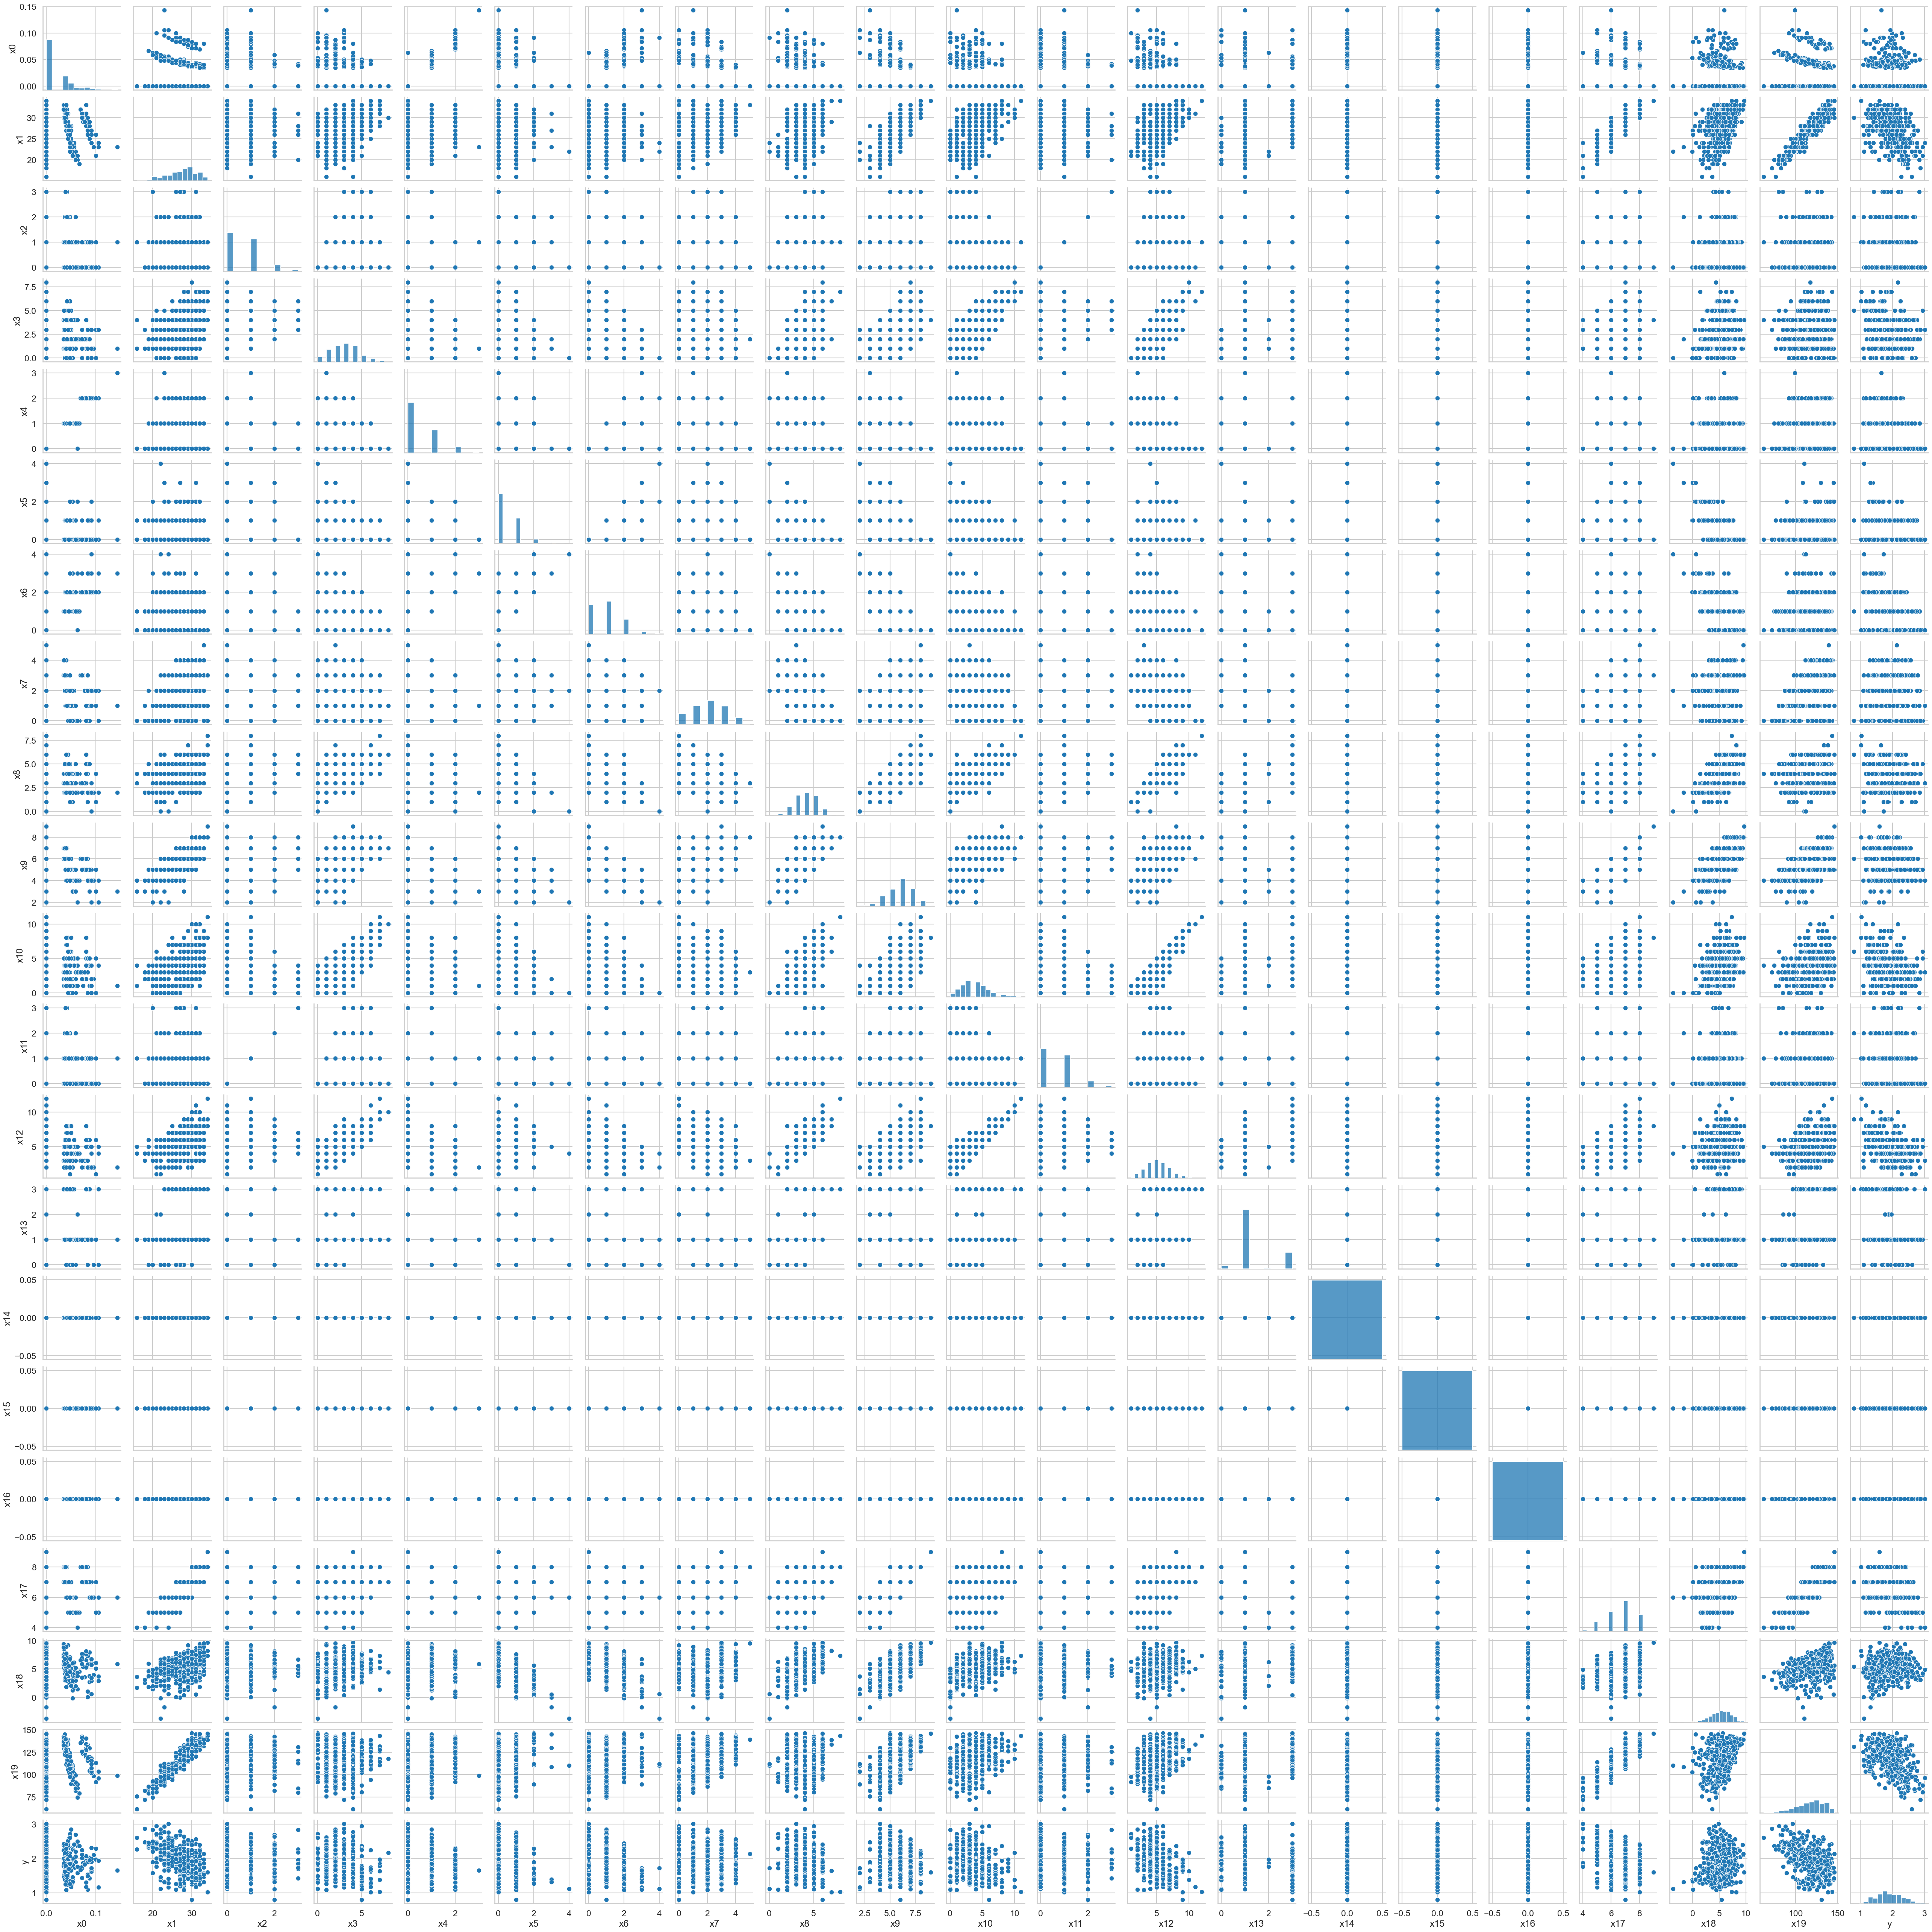

In [135]:
sns.pairplot(dev)

<font size=4>There are clearly some relationships to observe:

- <font size=4> $x16$ takes on only a single value in the whole dataset

- <font size=4> $x1$ and $x19$ are highly correlated

### A. By filtering

<font size=5><center>Before we do anything clever we can __just compute some measures of the data itself independant of any ML model__. We can use these to filter out some features.

<font size=4>Which data are related to the target according for example pearson correlation coefficient? There are other measures of correlation, see [here](https://www.analyticsvidhya.com/blog/2021/09/different-type-of-correlation-metrics-used-by-data-scientist/).

In [139]:
dev.corr(method='pearson')['y']

x0    -0.122011
x1    -0.463488
x2    -0.034474
x3    -0.215338
x4    -0.137794
x5    -0.323083
x6    -0.353101
x7    -0.033883
x8    -0.088982
x9    -0.121640
x10   -0.270738
x11   -0.034474
x12   -0.420016
x13   -0.227849
x14         NaN
x15         NaN
x16         NaN
x17   -0.443772
x18    0.173453
x19   -0.480142
y      1.000000
Name: y, dtype: float64

<font size=4>There is a low hanging fruit here - features 14 15 and 16 have `NaN` correlation. This means the pearson-r mathematically could not be calculate. These are the features that are the same value for the full dataset, and we can definately remove them.

In [140]:
features_to_remove = ['x14', 'x15', 'x16']